
 Number of features :  14

 Train Result: 
 RMSE_scaled  RMSE   MAE   R2-Score    Generator Loss    Discriminator Loss
_________________________________________________________________________
0 :  0.741     25903.41   23487.67   -1.176    -0.011    9.542
1 :  0.628     21951.59   20117.74   -0.563    -0.022    9.127
2 :  0.493     17219.96   16049.27   0.038    -0.041    8.688
3 :  0.363     12696.96   11865.06   0.477    -0.072    8.148
4 :  0.293     10232.81   8583.78   0.660    -0.112    7.571
5 :  0.304     10627.88   6918.11   0.634    -0.165    6.878
6 :  0.369     12913.42   8360.36   0.459    -0.231    6.051
7 :  0.447     15618.57   10779.18   0.209    -0.311    5.033
8 :  0.518     18111.19   12667.47   -0.064    -0.405    3.969
9 :  0.576     20134.55   14012.04   -0.315    -0.509    2.916
10 :  0.618     21594.83   14914.65   -0.513    -0.617    2.006
11 :  0.643     22495.47   15461.37   -0.641    -0.710    1.428
12 :  0.658     23012.50   15776.16   -0.718    -0.768   

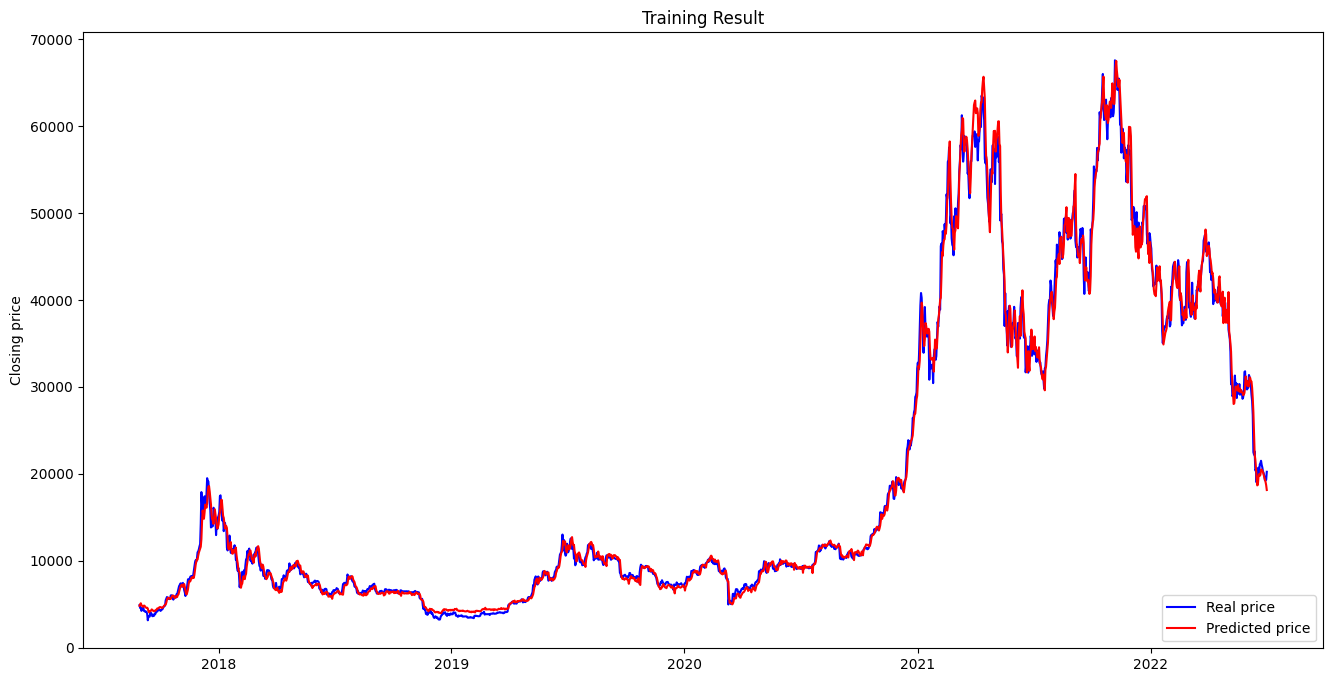

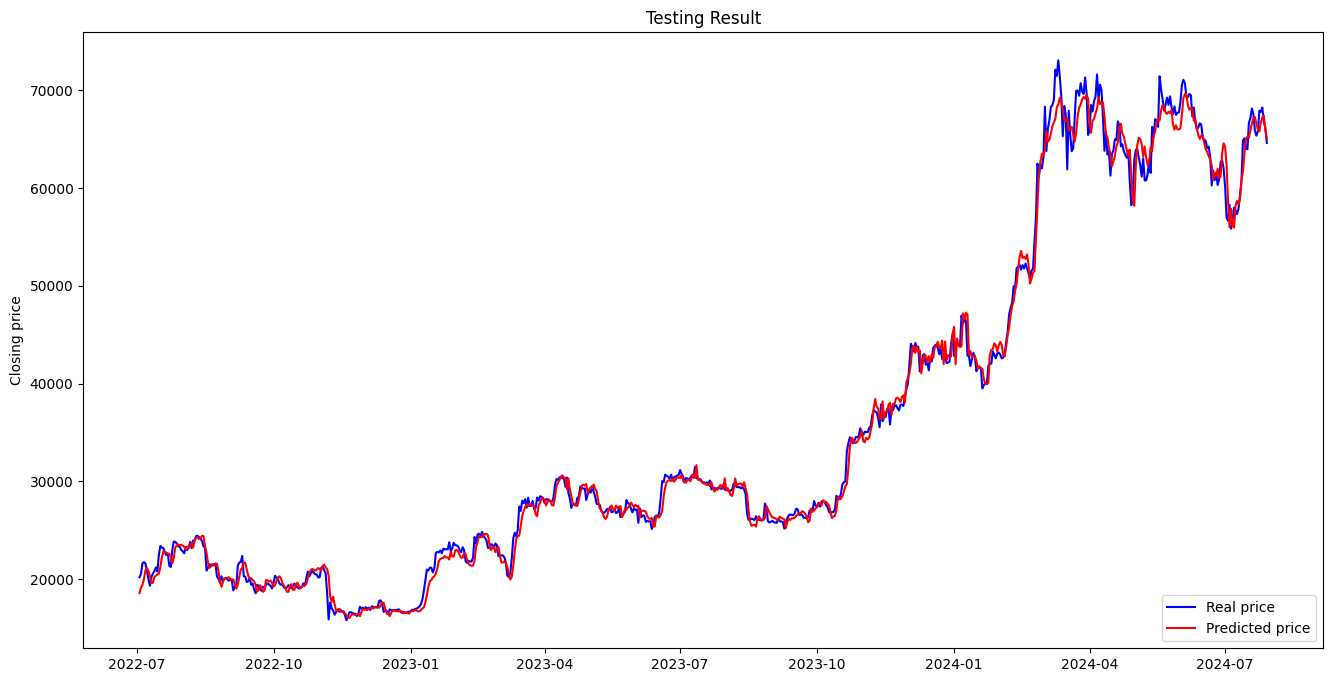

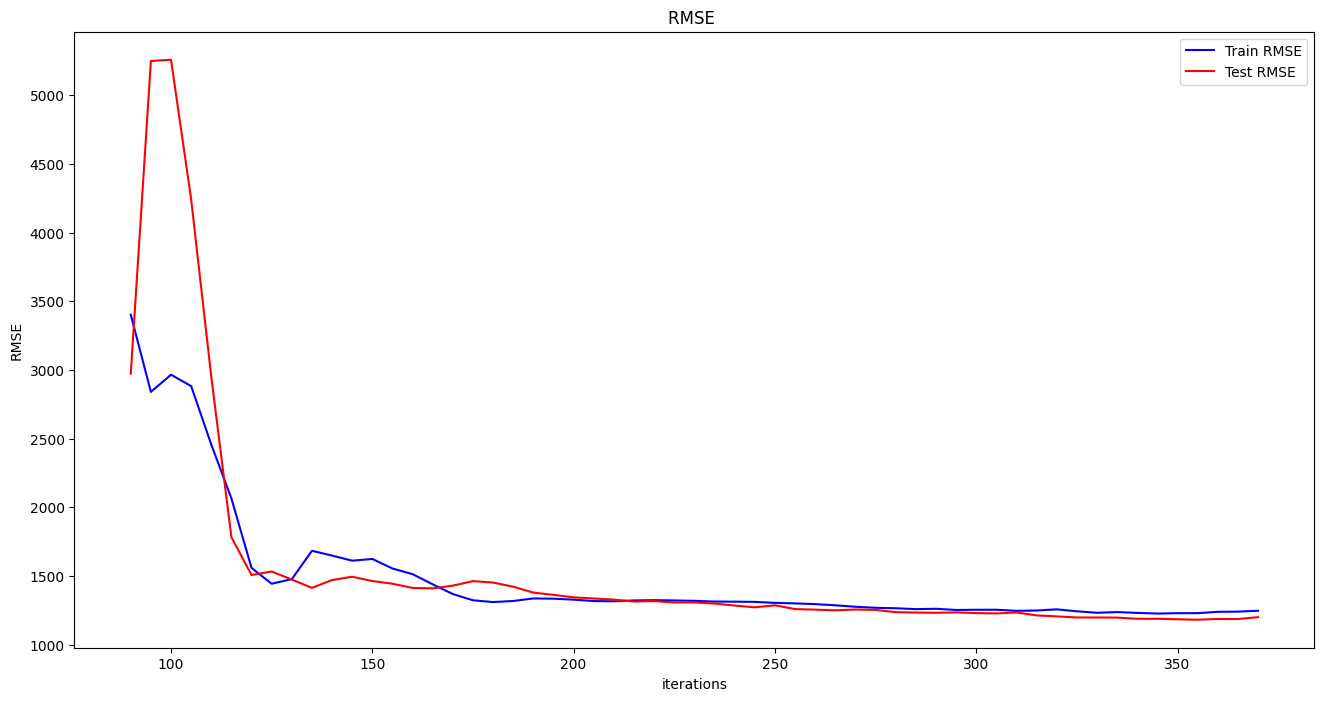

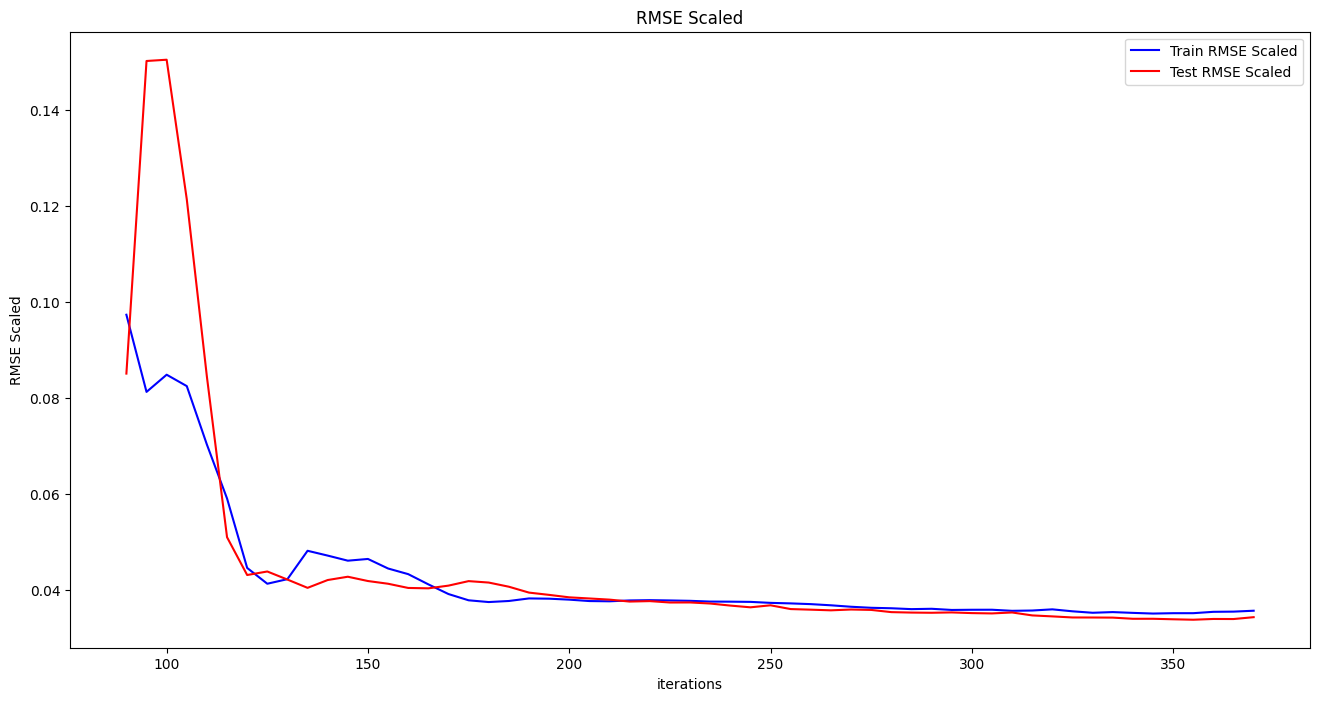

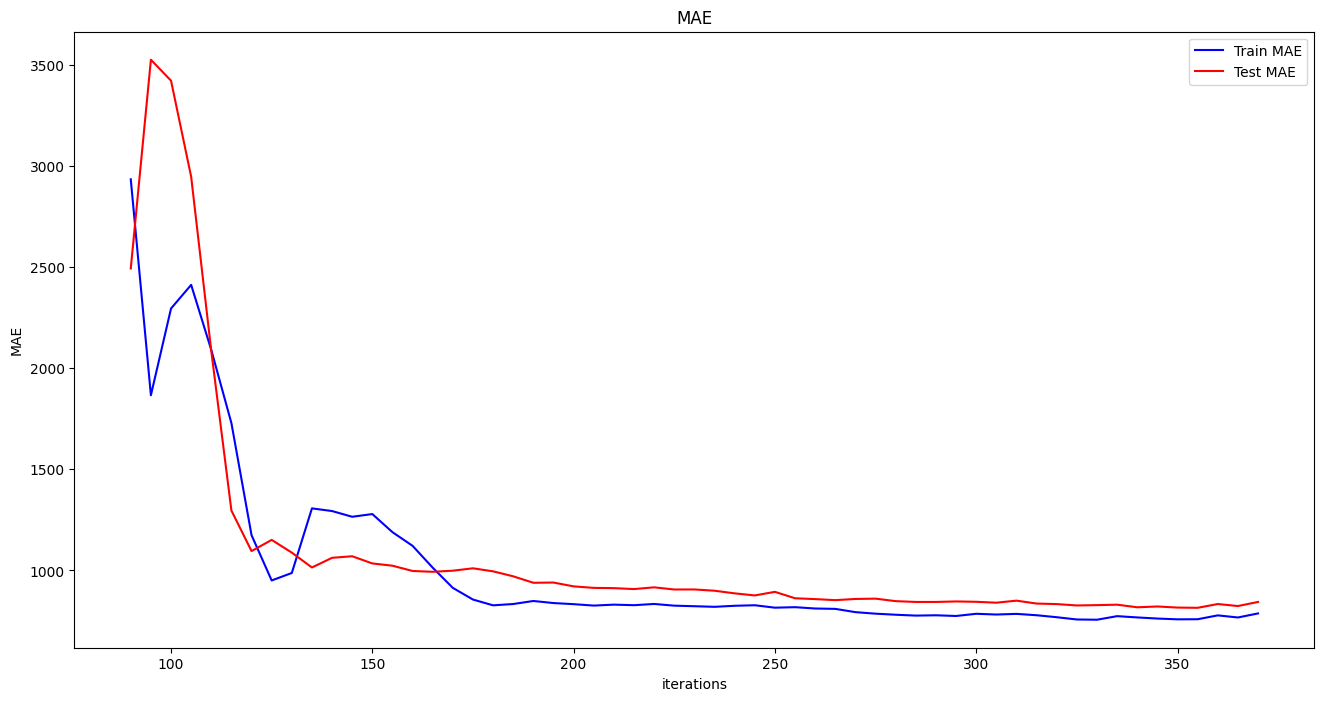

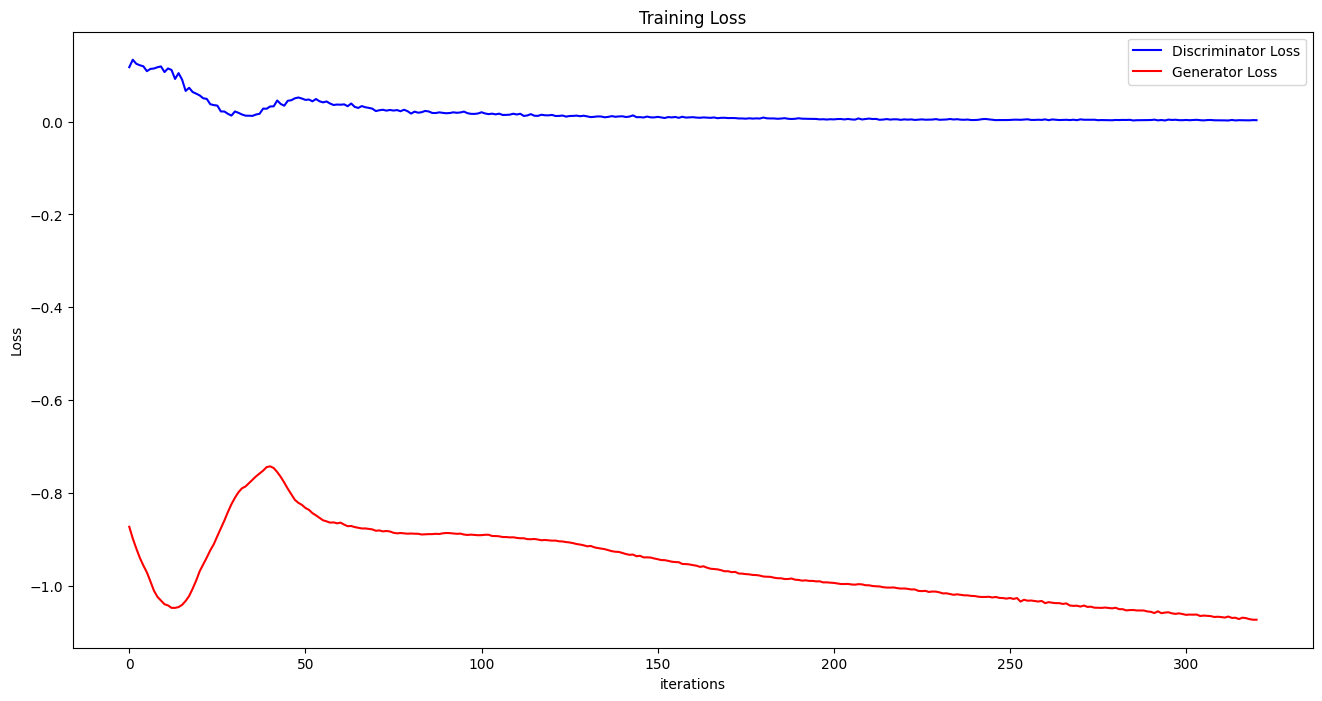

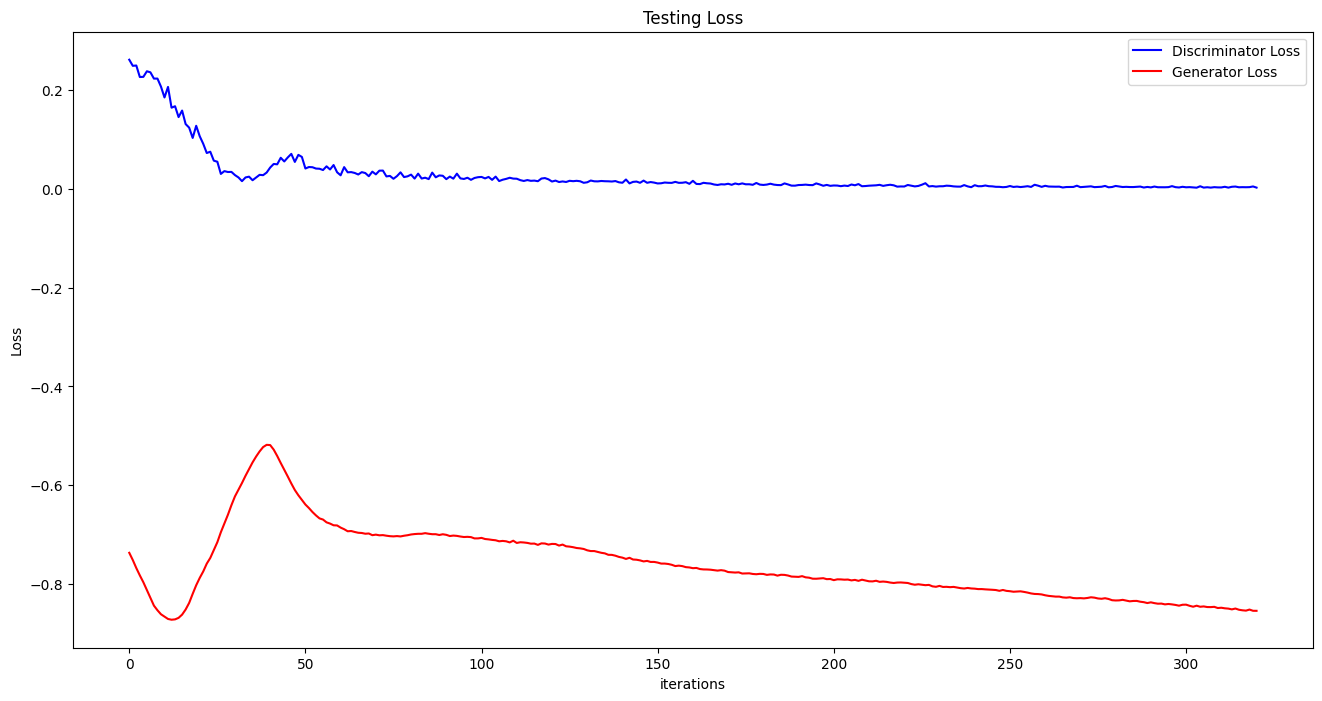

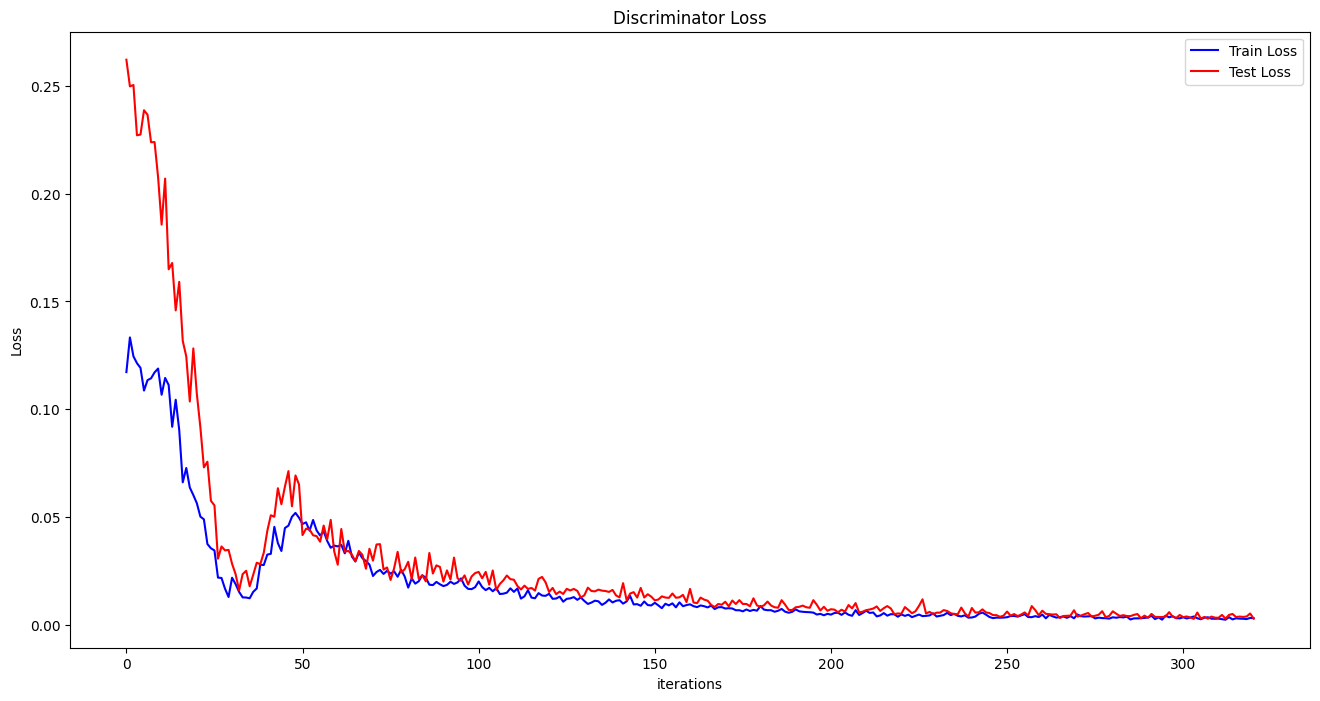

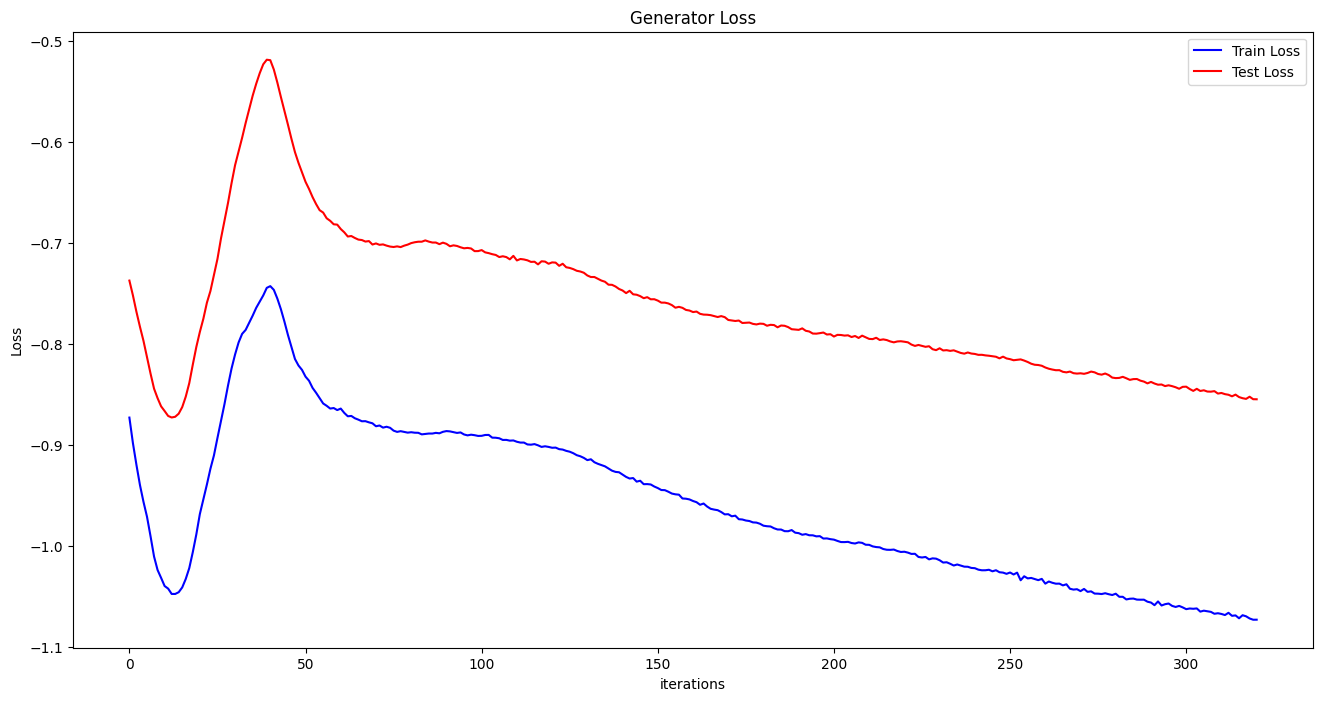

In [44]:
import ta
import numpy as np
import pandas as pd
import sklearn.preprocessing as sk
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras; from tensorflow.keras import layers;
from tensorflow.keras import metrics
from keras.layers import Dense, Flatten, GRU, LSTM, Conv1D, LeakyReLU, ReLU, BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention, Add, Reshape, SpectralNormalization, Concatenate
from keras import regularizers
from keras.metrics import mean_squared_error, mean_absolute_error
import random
import warnings
warnings.filterwarnings("ignore")

class Process_Data(object):
    def __init__(self, file_name, input_win, output_win):
        self.name = file_name
        self.input_win = input_win
        self.output_win = output_win
        
    def load_data(self):
        # Load raw stock data from file_name.csv
        self.raw_data = pd.read_csv(self.name, parse_dates=['Date'])
        #print(self.raw_data.columns)
        
    def extract_features(self):
        # Extract features from raw data based on technical indicators 
        
        # Clean nan values
        df = ta.utils.dropna(self.raw_data)
       
        # Add upper band of bollinger band while filling nans values
        df["BB_H_indicator"] = ta.volatility.bollinger_hband(df["Close"], window=20, window_dev=2, fillna=True)

        # Add lower band of bollinger band
        df["BB_l_indicator"] = ta.volatility.bollinger_lband(df["Close"], window=20, window_dev=2, fillna=True)

        # Add middle of bollinger band 
        df["BB_MA_indicator"] = ta.volatility.bollinger_mavg(df["Close"], window=20, fillna=True)
        
        # Add Relative Strength Index (RSI) 
        df["RSI"] = ta.momentum.rsi(df["Close"], window=14, fillna=True)
        
        # Add Stochastic RSI
        df["Stoch"] = ta.momentum.stochrsi(df["Close"], window=14, smooth1=3, smooth2=3, fillna=True)
        
        # Add Moving Average Convergence Divergence (MACD)
        df["MACD"] = ta.trend.macd(df["Close"], window_slow=26, window_fast=12, fillna=True)
        
        # Add Exponential Moving Average (EMA)
        df["EMA"] = df["Close"].ewm(com=0.5).mean()

        # Add log of momentum
        df['log_momentum'] = np.log(df["Close"] - 1)
        
        # Add Ichimoku
        #df["Ichi"] = ta.trend.ichimoku_base_line(df["High"], df["Low"], window1=9, window2=26, visual=False, fillna=True)

        # Add Exponential Moving Average (EMA) indicator
        #df["EMA_ind"] = ta.trend.ema_indicator(df["Close"], window=12, fillna=True)
        
        # Add Moving Average
        #df['MA7'] = df["Close"].rolling(window=7).mean()
        #df['MA21'] = df["Close"].rolling(window=21).mean()
        
        df_new = df.iloc[20:,:].reset_index(drop=True)
        #print(df.columns)
        print('\n Number of features : ',len(df.columns)-1)
        df_new.to_csv("feature_data.csv", index=False)
        date_ = pd.to_datetime(df_new['Date'])
        index_ = pd.DatetimeIndex(date_.values)
        df_new = df_new.set_index(index_)
        df_new = df_new.sort_values(by='Date')
        df_new = df_new.drop(columns='Date')
        
        # Transform features by scaling each feature to (-1,1) range
        df_new_y = pd.DataFrame(df_new.iloc[:, 3])
        self.scaler_y = sk.MinMaxScaler(feature_range=(-1, 1))
        self.data_y = self.scaler_y.fit_transform(df_new_y)
        
        self.scaler_x = sk.MinMaxScaler(feature_range=(-1, 1))
        self.feature_data = self.scaler_x.fit_transform(df_new)
        
        return df_new
    
    def windowing(self):
        # Perform windowing to generate data segments with size (input_win * M) 
        # where M is number of features 
        
        # Define historical prices and target price
        segments = [] # input segments for generator 
        h_prices = [] # historical prices in Fig.1 of paper
        y = []        # target price 
        index_ = len(self.feature_data) - self.input_win - self.output_win + 1
        for i in range(index_):
            segment_i = self.feature_data[i: i + self.input_win, :] 
            segments.append(segment_i)
            h_price_i = self.data_y[i: i + self.input_win, :] 
            h_prices.append(h_price_i)
            y_i = self.data_y[i + self.input_win: i + (self.input_win + self.output_win), :]
            y.append(y_i)
        
        self.segments = np.array(segments)
        self.h_prices = np.array(h_prices)
        self.y = np.array(y)
        

# Define DRAGAN and it's components 
class Discriminator(tf.keras.Model):
    def __init__(self, input_win, output_win):
        super().__init__(name='Discriminator')
        self.l1 = Conv1D(32, input_shape=(input_win+output_win, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
        self.l2 = Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
        self.l3 = Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01))
        self.l4 = Flatten()
        self.l5 = Dense(220, use_bias=True, activation=LeakyReLU())
        self.l6 = Dense(220, use_bias=True, name='feature_layer')
        self.l7 = ReLU()
        self.l8 = Dense(1)

    def call(self, inputs):
        features = self.l1(inputs)
        features = self.l2(features)
        features = self.l3(features)
        features = self.l4(features)
        features = self.l5(features)
        features = self.l6(features)
        features_last = self.l7(features)
        return self.l8(features_last), features

class Generator(tf.keras.Model):
    def __init__(self, input_win, output_win, feature_m):
        super().__init__(name='Generator')
        #Hybrid lstm
        self.g1 = Conv1D(256, kernel_size=3, padding="same", activation='relu', input_shape=(input_win, feature_m))
        self.g2 = LSTM(256, return_sequences=True)
        self.g3 = Flatten()
        self.g4 = Dense(units=output_win, activation='tanh')
        
    def call(self, inputs):
        features = self.g1(inputs)
        features = self.g2(features)
        features = self.g3(features)
        return self.g4(features)

class DRAGAN(object):
    def __init__(self, input_win, output_win, feature_m):
        self.input_win = input_win
        self.output_win = output_win
        self.feature_m = feature_m
        self.disc = Discriminator(input_win, output_win)
        self.gen = Generator(input_win, output_win, feature_m)
        self.disc.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
        self.gen.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
        
    def DRAGAN_penalty(self, real_data):
        real_data = tf.cast(real_data, tf.float32)
        def _interpolate(a):
            beta = tf.random.uniform(tf.shape(a), 0., 1.)
            b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape, 0., 1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter
        
        x = _interpolate(real_data)
        with tf.GradientTape() as tape:
            tape.watch(x)
            predictions, _ = self.disc(x, training=True)
        grad = tape.gradient(predictions, x)
        slopes = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        return tf.reduce_mean((slopes - 1.) ** 2)
    
    def train(self, segment_train, y_target, historical_price):
        # N = size of each segment 
        N = segment_train.shape[0]
        
        # Define feature matching layer
        # m = self.disc
        # intermediate_layer_model = Model(inputs=m.input, outputs=m.get_layer('feature_layer').output)
        
        # Train discriminator
        for step in range(3):
            #y_predict = self.gen(segment_train) # training=True  ???
            with tf.GradientTape() as disc_tape:                
                # y_target = tf.expand_dims(y_train, axis=2)
                # historical_price = tf.expand_dims(h_prices_train, axis=2)
                X_real =  tf.concat([historical_price, y_target], axis=1)
                output_real, _ = self.disc(X_real, training=True)
                           
                y_predict = self.gen(segment_train) # training=True  ???
                y_predict = tf.expand_dims(y_predict, axis=2)
                X_fake =  tf.concat([historical_price, tf.cast(y_predict, tf.float64)], axis=1)
                output_fake, _ = self.disc(X_fake, training=True)
                
                penalty_term = self.DRAGAN_penalty(X_real)
                main_loss = tf.reduce_mean(output_fake) - tf.reduce_mean(output_real)
                disc_loss = main_loss + 10.0 * penalty_term
            grads = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
            self.disc.optimizer.apply_gradients(zip(grads, self.disc.trainable_variables))
            
        # Train generator  
        for step in range(3):
            with tf.GradientTape() as gen_tape:                
                y_predict = self.gen(segment_train, training=True) 
                y_predict = tf.expand_dims(y_predict, axis=2)
                X_fake =  tf.concat([historical_price, tf.cast(y_predict, tf.float64)], axis=1)
                output_fake, _ = self.disc(X_fake, training=True)
                
                # y_target = tf.expand_dims(y_train, axis=2)
                # X_real =  tf.concat([historical_price, y_target], axis=1)
                
                # compute feature matching based on specific layer of discriminator
                _, feature_real = self.disc(X_real, training=True)  #??? True, or stop.gradiant
                _, feature_fake = self.disc(X_fake, training=True)
                norm_diff = tf.square(feature_real - feature_fake)
                #mean_diff = tf.reduce_mean(norm_diff, axis = 1)
                feature_matching = tf.reduce_mean(norm_diff)
               
                gen_loss = -tf.reduce_mean(output_fake) + feature_matching
                #print(-tf.reduce_mean(output_fake) , feature_matching)
            grad = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
            self.gen.optimizer.apply_gradients(zip(grad, self.gen.trainable_variables))
        return np.array(disc_loss), np.array(gen_loss), y_predict
    
    # test for one output, uncomment this code when output_win<2
    def test(self, segment_test_t):
        self.gen.load_weights('DRAGAN_best.weights.h5')
        y_predict_ = self.gen(segment_test_t) 
        return y_predict_
   
def split_train_test(data):
    train_size = round(len(data) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

def multi_output(y_true, y_pred):
    # Average on multiple-output prediction and convert to one- output prediction
    y_true = tf.reshape(y_true, [y_true.shape[0], y_true.shape[1]])
    # y1 = stock_data.scaler_y.inverse_transform(y_true)
    # y2 = stock_data.scaler_y.inverse_transform(y_pred)
    y1 = y_true
    y2 = y_pred
    pd_y_true = pd.DataFrame()
    for i in range(y1.shape[0]):
        train_i = pd.DataFrame(y1[i], columns=["y_true"], index = pd.Index(range(i,i+output_win,1)))
        pd_y_true = pd.concat([pd_y_true, train_i], axis=1, sort=False)
    pd_y_pred = pd.DataFrame()
    for i in range(y2.shape[0]):
        predict_i = pd.DataFrame(y2[i], columns=["y_pred"], index = pd.Index(range(i,i+output_win,1)))
        pd_y_pred = pd.concat([pd_y_pred, predict_i], axis=1, sort=False)
        
    out1 = tf.reshape(pd_y_true.mean(axis=1)[0:y1.shape[0]], [y1.shape[0],1])
    out2 = tf.reshape(pd_y_pred.mean(axis=1)[0:y2.shape[0]], [y2.shape[0],1])
    return out1, out2
    
def compute_RMSE_MAE(y_true, y_pred):
    RMSE_scaled = np.sqrt(mean_squared_error(tf.squeeze(y_true), tf.squeeze(y_pred)))
    
    r1 = tf.reshape(y_true, [y_true.shape[0], y_true.shape[1]])
    r2 = tf.reshape(y_pred, [y_pred.shape[0], y_pred.shape[1]])
    y1 = stock_data.scaler_y.inverse_transform(r1)
    y2 = stock_data.scaler_y.inverse_transform(r2)
    RMSE = np.sqrt(mean_squared_error(tf.squeeze(y1), tf.squeeze(y2)))
    
    MAE = mean_absolute_error(tf.squeeze(y1), tf.squeeze(y2))
    
    #R2 = r2_score(tf.squeeze(y1), tf.squeeze(y2), multioutput='variance_weighted')
    R2 = r2_score(y1, y2)
    
    # unexplained_error = tf.reduce_sum(tf.square(y1 -y2 ))
    # total_error = tf.reduce_sum(tf.square(y1 - tf.reduce_mean(y1, axis=0)))
    # R22 = 1. - tf.divide(unexplained_error, total_error)
    # print(ew, R22)    
    return RMSE_scaled, RMSE, np.array(MAE), R2

def plot_result(y_true, y_pred, train = True):
    # Plot predicted prices against real prices
    r1 = tf.reshape(y_true, [y_true.shape[0], y_true.shape[1]])
    r2 = tf.reshape(y_pred, [y_pred.shape[0], y_pred.shape[1]])   
    y1 = stock_data.scaler_y.inverse_transform(r1)
    y2 = stock_data.scaler_y.inverse_transform(r2)
    
    if train:
        title = 'Training Result'
        date= train_date
    else:
        title = 'Testing Result'
        date = test_date
    
    plt.figure(figsize=(16, 8))
    plt.title(title)
    plt.plot(date, y1, color= 'blue')
    plt.plot(date, y2, color= 'red')
    plt.xlabel('')
    plt.ylabel('Closing price')
    plt.legend(("Real price", "Predicted price"), loc="lower right")
    plt.show()
    
    
if __name__ == '__main__':
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    #iterations = 371
    iterations = 371
    input_win = 2
    output_win = 1
    
    # Preprocessing, extracting features and windowing on raw data  
    stock_data = Process_Data('BTC-USD.csv', input_win, output_win)
    stock_data.load_data()
    df_feature = stock_data.extract_features()
    stock_data.windowing()
    
    # Partition data into train and test sets
    segment_train, segment_test = split_train_test(stock_data.segments)
    y_train, y_test = split_train_test(stock_data.y)
    h_prices_train, h_prices_test = split_train_test(stock_data.h_prices)
    
    # Save the date column to calculate RMSE and plot    
    train_date = df_feature.iloc[0:segment_train.shape[0], :].index
    test_date = df_feature.iloc[segment_train.shape[0]:segment_train.shape[0]+ segment_test.shape[0] , :].index

    # Define DRAGAN and initialize
    feature_m = segment_train.shape[2]
    DRAGAN_model = DRAGAN(input_win, output_win, feature_m)
    
    # Initialize variables for tracking the best RMSE
    best_rmse = np.inf
    best_epoch = 0
    
    # Train DRAGAN 
    dis_loss = []
    gen_loss = []
    dis_loss_test = []
    gen_loss_test = []
    predicted_price = []
    target_price = []
    if output_win < 2:
        print('\n Train Result: \n RMSE_scaled', ' RMSE', '  MAE', '  R2-Score', '   Generator Loss', '   Discriminator Loss')
    print('_________________________________________________________________________')
    for iteration in range(iterations):
        dis_loss_, gen_loss_, y_predict = DRAGAN_model.train(segment_train, y_train, h_prices_train)
        dis_loss.append(dis_loss_)
        gen_loss.append(gen_loss_)
        
        if output_win < 2:
            RMSE_scaled, RMSE, MAE, R2 = compute_RMSE_MAE(y_train, y_predict)
            #print("iteration: {0: 5} RMSE_Train: {3: 5}".format(iteration, RMSE))
            print(iteration,': ', '{:.3f}'.format(RMSE_scaled),'   ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.3f}'.format(R2),'  ' , '{:.3f}'.format(gen_loss_) ,'  ' , '{:.3f}'.format(dis_loss_))
            # Checkpoint mechanism: Save the model if current RMSE is the best so far
            if RMSE < best_rmse and iteration > 140:
                best_rmse = RMSE
                best_epoch = iteration
                DRAGAN_model.gen.save_weights('DRAGAN_best.weights.h5')
        else:
            print('iteration: ', iteration)
            
        if (iteration % 5) == 0 and iteration > 70:
            print(iteration)
            DRAGAN_model.gen.save_weights('DRAGAN_%d.weights.h5' % iteration)
            #tf.keras.models.save_model(DRAGAN_model.gen, 'DRAGAN_%d.h5' % iteration, save_format='tf')
        
        dis_loss_test_, gen_loss_test_, y_predict_test1 = DRAGAN_model.train(segment_test, y_test, h_prices_test)
        dis_loss_test.append(dis_loss_test_)
        gen_loss_test.append(gen_loss_test_)

    #DRAGAN_model.gen.save_weights('DRAGAN_last.weights.h5')
    
    print(f'Best RMSE:', '{:.2f}'.format(best_rmse),' at epoch', best_epoch)
    print('\n=========================================================================')
    
    if output_win < 2:
        #show result based best epoch
        y_predict_test = DRAGAN_model.test(segment_test)
        RMSE_scaled, RMSE, MAE, R2 = compute_RMSE_MAE(y_test, y_predict_test)
        #test_predicted_price = float(stock_data.scaler_y.inverse_transform(tf.reshape(y_predict_test, [y_predict_test.shape[0], y_predict_test.shape[1]]))[-1])
        print('\n Test Result:\n  RMSE_scaled', ' RMSE', '   MAE', '  R2-Score')
        print('_________________________________________________________________________')
        #print('\nTest: ', '{:.3f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.3f}'.format(R2),' ', '{:.2f}'.format(test_predicted_price),' ', test_date[-1])
        print('\nTest: ', '{:.3f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.3f}'.format(R2))
        y_predict_train = DRAGAN_model.test(segment_train)
        RMSE_scaled, RMSE, MAE, R2 = compute_RMSE_MAE(y_train, y_predict_train)
        #train_predicted_price = float(stock_data.scaler_y.inverse_transform(tf.reshape(y_predict_train, [y_predict_train.shape[0], y_predict_train.shape[1]]))[-1])
        print('\n   RMSE_scaled', ' RMSE', '   MAE', '  R2-Score')
        print('_________________________________________________________________________')
        #print('\nTrain:', '{:.3f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.3f}'.format(R2),' ', '{:.2f}'.format(train_predicted_price),' ', train_date[-1])
        print('\nTrain:', '{:.3f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.3f}'.format(R2))
        
        plot_result(y_train, y_predict_train, train = True)
        plot_result(y_test, y_predict_test, train = False)

    else:        
        y_predict_test = DRAGAN_model.test(segment_test)
        y_test_, y_predict_test_ = multi_output(y_test, y_predict_test)
        RMSE_scaled, RMSE, MAE, R2 = compute_RMSE_MAE(y_test_, y_predict_test_)  
        print('_________________________________________________________________________')
        print('\nTest: ', '{:.2f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.2f}'.format(R2))
        
        y_predict_train = DRAGAN_model.test(segment_train)
        y_train_, y_predict_train_ = multi_output(y_train, y_predict_train)        
        RMSE_scaled, RMSE, MAE, R2 = compute_RMSE_MAE(y_train_, y_predict_train_)     
        print('_________________________________________________________________________')
        print('\nTrain:', '{:.2f}'.format(RMSE_scaled),'  ' , '{:.2f}'.format(RMSE),' ', '{:.2f}'.format(MAE),' ', '{:.2f}'.format(R2))
        
        plot_result(y_train_, y_predict_train_, train = True)
        plot_result(y_test_, y_predict_test_, train = False)

    train_list = []
    test_list = []
    train_list_scaled = []
    test_list_scaled = []
    test_list_mae = []
    train_list_mae = []
    index_e = []  
    for i in range(90, iterations, 5):
        index_e.append(i)
        DRAGAN_model.gen.load_weights('DRAGAN_%d.weights.h5' % i)
        y_p = DRAGAN_model.gen(segment_test)
        RMSE_scaled1, RMSE1, MAE1, R21 = compute_RMSE_MAE(y_test, y_p)
        test_list.append(RMSE1)
        test_list_scaled.append(RMSE_scaled1)
        test_list_mae.append(MAE1)
        y_p = DRAGAN_model.gen(segment_train)
        RMSE_scaled1, RMSE1, MAE1, R21 = compute_RMSE_MAE(y_train, y_p)
        train_list.append(RMSE1)
        train_list_scaled.append(RMSE_scaled1)
        train_list_mae.append(MAE1)

    plt.figure(figsize=(16, 8))
    plt.title('RMSE ')
    plt.plot(index_e, train_list , color= 'blue')
    plt.plot(index_e, test_list, color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('RMSE')
    plt.legend(("Train RMSE", "Test RMSE"), loc="upper right")
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title('RMSE Scaled')
    plt.plot(index_e, train_list_scaled , color= 'blue')
    plt.plot(index_e, test_list_scaled, color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('RMSE Scaled')
    plt.legend(("Train RMSE Scaled", "Test RMSE Scaled"), loc="upper right")
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title('MAE')
    plt.plot(index_e, train_list_mae , color= 'blue')
    plt.plot(index_e, test_list_mae, color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('MAE')
    plt.legend(("Train MAE", "Test MAE"), loc="upper right")
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.title('Training Loss')
    plt.plot(dis_loss[50:], color= 'blue')
    plt.plot(gen_loss[50:], color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend(("Discriminator Loss", "Generator Loss"), loc="upper right")
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title('Testing Loss')
    plt.plot(dis_loss_test[50:], color= 'blue')
    plt.plot(gen_loss_test[50:], color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend(("Discriminator Loss", "Generator Loss"), loc="upper right")
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title('Discriminator Loss')
    plt.plot(dis_loss[50:], color= 'blue')
    plt.plot(dis_loss_test[50:], color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend(("Train Loss", "Test Loss"), loc="upper right")
    plt.show()

    plt.figure(figsize=(16, 8))
    plt.title('Generator Loss')
    plt.plot(gen_loss[50:], color= 'blue')
    plt.plot(gen_loss_test[50:], color= 'red')
    plt.xlabel('iterations')
    plt.ylabel('Loss')
    plt.legend(("Train Loss", "Test Loss"), loc="upper right")
    plt.show()